In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
true = pd.DataFrame()
true['Si/Al'] = [10., 14.3, 10., 10.]
true['sda1/Si'] = [0.15, 0.15, 0.35, 0.1]
true['Na/Si'] = [0.2, 0.2, 0.3, 0.2]
true['K/Si'] = [0., 0., 0., 0.]
true['H2O/Si'] = [15., 15., 15., 15.]
true['cryst_temp'] = [175., 175., 175., 175.]
true['cryst_time'] = [168., 168., 168., 168.]
true

,Si/Al,sda1/Si,Na/Si,K/Si,H2O/Si,cryst_temp,cryst_time
0,10.0,0.15,0.2,0.0,15.0,175.0,168.0
1,14.3,0.15,0.2,0.0,15.0,175.0,168.0
2,10.0,0.35,0.3,0.0,15.0,175.0,168.0
3,10.0,0.10,0.2,0.0,15.0,175.0,168.0


In [16]:
pred = pd.read_csv('syn_pred.csv')
pred = pred[pred['Si/Al'] > 0]

# Preprocess to unnormalized molar ratios
hets = ['Al', 'Ge', 'B']
thresholds = [0.00251, 0.099990, 0.004001]
for het, thres in zip(hets, thresholds):

    pred[f'{het}/Si'] = 1. / pred[f'Si/{het}']
    pred[f'{het}/Si'] = pred[f'{het}/Si'].map(lambda x: 1e-4 if x <= thres else x)
    pred[f'{het}'] = pred[f'{het}/Si']
    pred['Si'] = [1.]*len(pred)

tot_hets = pred[['Si']+hets].sum(1) # sum of heteroatoms fractions

for c in ['Na', 'K', 'OH', 'F', 'H2O', 'sda1']:
    pred[f'{c}'] = pred[f'{c}/T'] * tot_hets
    pred[f'{c}/Si'] = pred[f'{c}'] / pred['Si']

pred

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,...,K,K/Si,OH,OH/Si,F,F/Si,H2O,H2O/Si,sda1,sda1/Si
0,6.493506,1.717997,99.0,250.0,0.182112,0.022678,0.243520,0.0,14.705882,0.062500,...,0.026175,0.026175,0.281070,0.281070,0.0,0.0,16.973529,16.973529,0.072138,0.072138
5,7.783688,1.717997,99.0,250.0,0.200000,0.049615,0.199852,0.0,13.333333,0.041667,...,0.055999,0.055999,0.225568,0.225568,0.0,0.0,15.048984,15.048984,0.047029,0.047029
8,7.581384,1.717997,99.0,250.0,0.233551,0.000000,0.166667,0.0,16.169056,0.080440,...,0.000000,0.000000,0.188684,0.188684,0.0,0.0,18.305021,18.305021,0.091067,0.091067
9,6.493506,1.717997,99.0,250.0,0.230288,0.000000,0.250000,0.0,12.500000,0.072178,...,0.000000,0.000000,0.288550,0.288550,0.0,0.0,14.427500,14.427500,0.083308,0.083308
10,6.515651,1.717997,99.0,250.0,0.344796,0.000000,0.052608,0.0,12.500000,0.050000,...,0.000000,0.000000,0.060693,0.060693,0.0,0.0,14.420958,14.420958,0.057684,0.057684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,7.109064,1.717997,99.0,250.0,0.330965,0.000000,0.000000,0.0,12.493381,0.050000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,14.253268,14.253268,0.057043,0.057043
995,6.493506,1.717997,99.0,250.0,0.287107,0.000000,0.196073,0.0,12.243384,0.083333,...,0.000000,0.000000,0.226307,0.226307,0.0,0.0,14.131314,14.131314,0.096183,0.096183
996,6.600000,1.717997,99.0,250.0,0.282658,0.000000,0.250000,0.0,13.031354,0.075000,...,0.000000,0.000000,0.287929,0.287929,0.0,0.0,15.008408,15.008408,0.086379,0.086379
998,6.600000,1.717997,99.0,250.0,0.296503,0.000000,0.149999,0.0,12.991538,0.064502,...,0.000000,0.000000,0.172756,0.172756,0.0,0.0,14.962551,14.962551,0.074288,0.074288


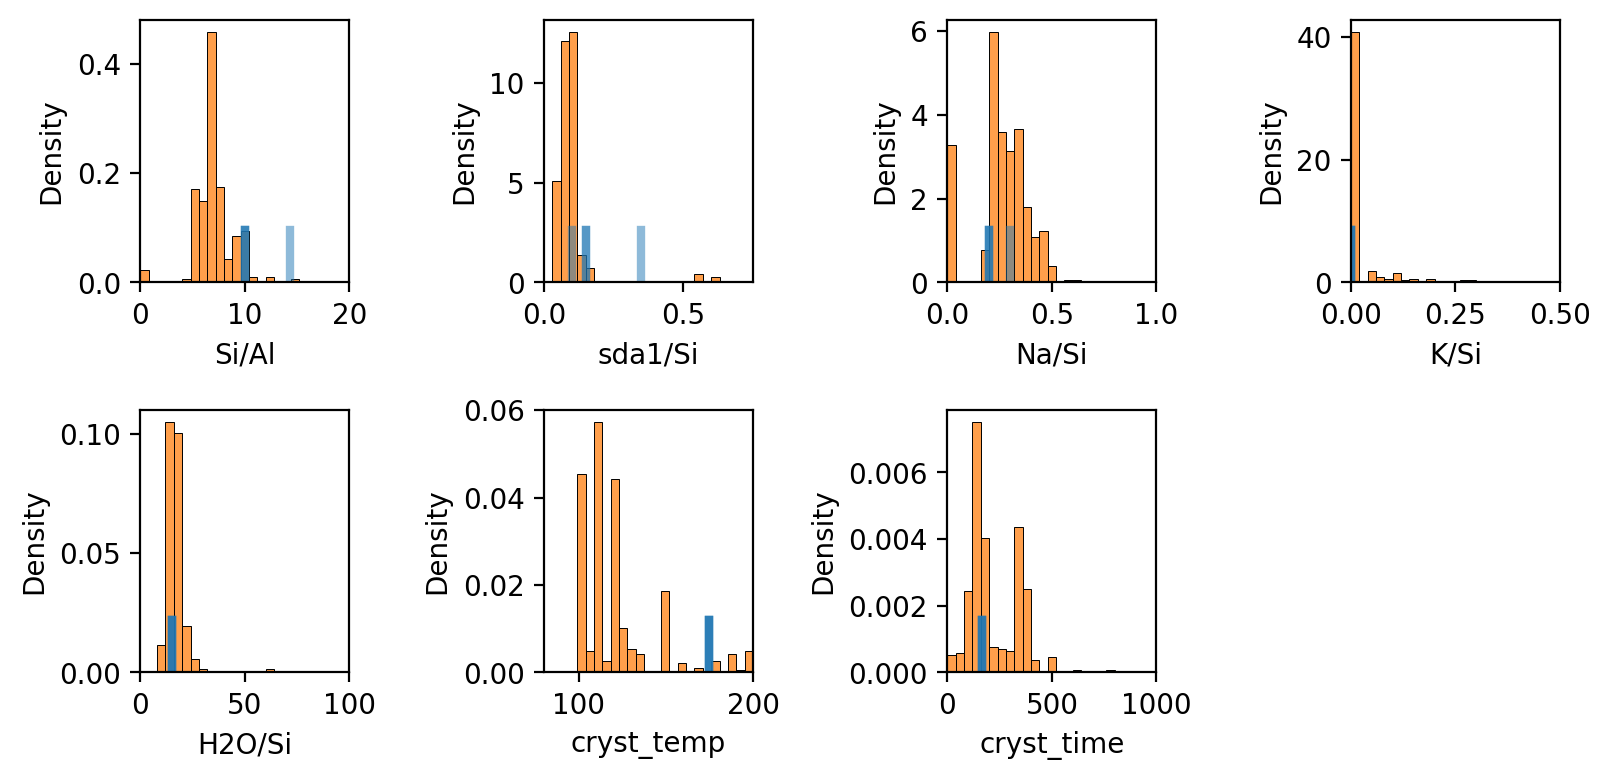

In [83]:
# Si/Al
col2spec = {'Si/Al': {'xlim': (0, 20)},
            'sda1/Si': {'xlim': (0, 0.75)},
            'Na/Si': {'xlim': (0, 1)},
            'K/Si': {'xlim': (0, 0.5)},
            'H2O/Si': {'xlim': (0, 100)},
            'cryst_temp': {'xlim': (80, 200)},
            'cryst_time': {'xlim': (0, 1000)},
            }

fig = plt.figure(figsize=(8, 4), dpi=200)

for i, col in enumerate(col2spec.keys()):
    ax = fig.add_subplot(2, 4, i+1)
    plot = sns.histplot(pred[col], color='tab:orange', label='Generated', 
                 binrange=col2spec[col]['xlim'], bins=25,
                 stat='density',
                #  kde=True, kde_kws={'bw_adjust': 0.5}
                 )
    ylim = plot.get_ylim()
    for v in true[col]:
        plt.plot([v, v], [0, 0.2 * ylim[-1]], color='tab:blue', linewidth=3, label='Experimental',
                 alpha=0.5
                 )
    plt.xlim(*col2spec[col]['xlim'])
# plt.legend()

plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

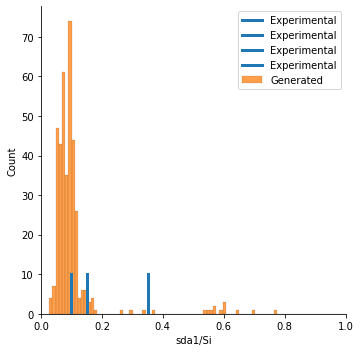

In [28]:
# sda1/Si
fig = plt.figure(figsize=(12, 6))
sns.displot(pred['sda1/Si'], color='tab:orange', label='Generated')
for v in true['sda1/Si']:
    plt.plot([v, v], [0, 10], color='tab:blue', linewidth=3, label='Experimental')
plt.xlim(0,1)
plt.legend()
plt.show()

<Figure size 864x432 with 0 Axes>

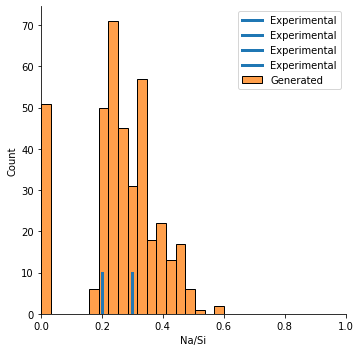

In [29]:
# Na/Si
fig = plt.figure(figsize=(12, 6))
sns.displot(pred['Na/Si'], color='tab:orange', label='Generated')
for v in true['Na/Si']:
    plt.plot([v, v], [0, 10], color='tab:blue', linewidth=3, label='Experimental')
plt.xlim(0,1)
plt.legend()
plt.show()

<Figure size 864x432 with 0 Axes>

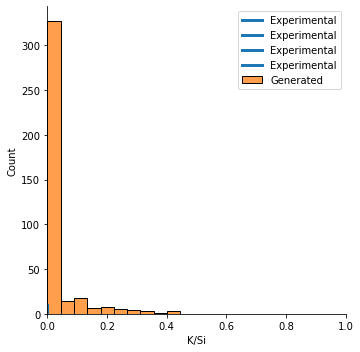

In [30]:
# K/Si
fig = plt.figure(figsize=(12, 6))
sns.displot(pred['K/Si'], color='tab:orange', label='Generated')
for v in true['K/Si']:
    plt.plot([v, v], [0, 10], color='tab:blue', linewidth=3, label='Experimental')
plt.xlim(0,1)
plt.legend()
plt.show()

<Figure size 864x432 with 0 Axes>

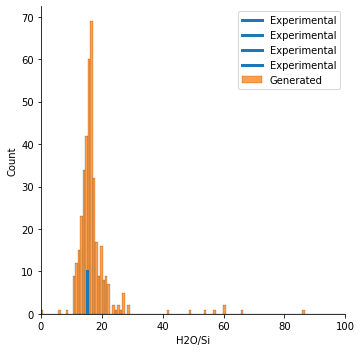

In [32]:
# H2O/Si
fig = plt.figure(figsize=(12, 6))
sns.displot(pred['H2O/Si'], color='tab:orange', label='Generated')
for v in true['H2O/Si']:
    plt.plot([v, v], [0, 10], color='tab:blue', linewidth=3, label='Experimental')
plt.xlim(0,100)
plt.legend()
plt.show()

<Figure size 864x432 with 0 Axes>

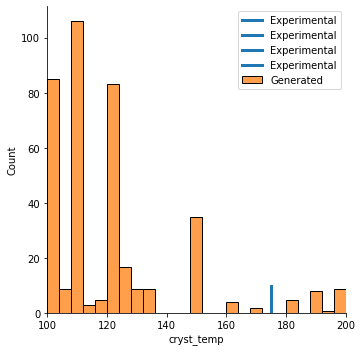

In [33]:
# cryst_temp
fig = plt.figure(figsize=(12, 6))
sns.displot(pred['cryst_temp'], color='tab:orange', label='Generated')
for v in true['cryst_temp']:
    plt.plot([v, v], [0, 10], color='tab:blue', linewidth=3, label='Experimental')
plt.xlim(100,200)
plt.legend()
plt.show()

<Figure size 864x432 with 0 Axes>

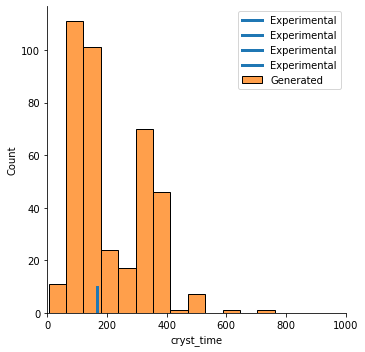

In [35]:
# cryst_time
fig = plt.figure(figsize=(12, 6))
sns.displot(pred['cryst_time'], color='tab:orange', label='Generated')
for v in true['cryst_time']:
    plt.plot([v, v], [0, 10], color='tab:blue', linewidth=3, label='Experimental')
plt.xlim(0,1000)
plt.legend()
plt.show()